# Wrangle And Analyze Data

**Author:** Ken Norton (ken@kennethnorton.com)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Wrangle-And-Analyze-Data" data-toc-modified-id="Wrangle-And-Analyze-Data-1">Wrangle And Analyze Data</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Gather" data-toc-modified-id="Gather-1.2">Gather</a></span></li><li><span><a href="#Assess" data-toc-modified-id="Assess-1.3">Assess</a></span></li><li><span><a href="#Clean" data-toc-modified-id="Clean-1.4">Clean</a></span><ul class="toc-item"><li><span><a href="#Quality-Issue:-Fix-Data-Types" data-toc-modified-id="Quality-Issue:-Fix-Data-Types-1.4.1">Quality Issue: Fix Data Types</a></span></li><li><span><a href="#Quality-Issue:-Doggie-Stage-Columns" data-toc-modified-id="Quality-Issue:-Doggie-Stage-Columns-1.4.2">Quality Issue: Doggie Stage Columns</a></span></li></ul></li></ul></li></ul></div>

## Introduction

Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

## Gather

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import ast
import sklearn
import json
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from IPython.display import Image
from IPython.display import display
from pandas.io.json import json_normalize 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Matplotlib styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# WeRateDogs twitter archive
df = pd.read_csv('data/twitter-archive-enhanced.csv')

# Image predictions
df_img = pd.read_csv('data/image-predictions.tsv', sep='\t')

In [4]:
'''
# I've commented this out now that I've generated the file,
# it took 30+ minutes to run so no need to do it again!

# Import my Twitter API keys from separate file
%run twitter-api.py

# Use Twitter API to fetch metadata for tweet_ids
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

# Extended tweet info from Twitter API
df_tweets = pd.read_json('data/tweet_json.txt', lines=True)

## Assess

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2337 non-null datetime64[ns]
display_text_range               2337 non-null object
entities                         2337 non-null object
extended_entities                2065 non-null object
favorite_count                   2337 non-null int64
favorited                        2337 non-null bool
full_text                        2337 non-null object
geo                              0 non-null float64
id                               2337 non-null int64
id_str                           2337 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 n

## Clean

In [8]:
# Rename df_tweets 'id' to 'tweet_id' to match
# the other dataframes
df_tweets.rename(columns={"id": "tweet_id"}, inplace=True)

# Now all of the dataframes share a tweet_id column
# so make that the index
df.set_index('tweet_id', inplace=True)
df_img.set_index('tweet_id', inplace=True)
df_tweets.set_index('tweet_id', inplace=True)

In [9]:
# Join the image predictions
df = df.join(df_img, how = 'inner')

# Join the extended tweet data
df = df.join(df_tweets, how = 'inner', lsuffix = '_x')

# Now drop the duplicated columns (ending in '_x')
df = df.drop(df.filter(regex='_x').columns, axis=1)

In [10]:
df.dtypes

timestamp                                object
text                                     object
retweeted_status_id                     float64
retweeted_status_user_id                float64
retweeted_status_timestamp               object
expanded_urls                            object
rating_numerator                          int64
rating_denominator                        int64
name                                     object
doggo                                    object
floofer                                  object
pupper                                   object
puppo                                    object
jpg_url                                  object
img_num                                   int64
p1                                       object
p1_conf                                 float64
p1_dog                                     bool
p2                                       object
p2_conf                                 float64
p2_dog                                  

In [11]:
df.describe()

,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,contributors,coordinates,...,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,7.500000e+01,7.500000e+01,2065.000000,2065.000000,2065.000000,2065.000000,2.065000e+03,2.065000e+03,0.0,0.0,...,2.065000e+03,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2065.0,2065.0,0.0,0.0,2065.000000
mean,7.628386e+17,1.049949e+16,12.263438,10.513801,1.203390,0.594381,1.347334e-01,6.036921e-02,NaN,NaN,...,7.380289e+17,6.978112e+17,6.978112e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,2752.823245
std,5.813066e+16,9.092825e+16,40.778642,7.194349,0.562291,0.270995,1.007085e-01,5.093950e-02,NaN,NaN,...,6.760956e+16,4.359384e+16,4.359384e+16,0.000000e+00,0.000000e+00,0.0,0.0,NaN,NaN,4801.211829
min,6.675094e+17,7.832140e+05,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,NaN,NaN,...,6.660209e+17,6.671522e+17,6.671522e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,11.000000
25%,7.118465e+17,4.196984e+09,10.000000,10.000000,1.000000,0.364095,5.390140e-02,1.624560e-02,NaN,NaN,...,6.764309e+17,6.732411e+17,6.732411e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,586.000000
50%,7.761133e+17,4.196984e+09,11.000000,10.000000,1.000000,0.587830,1.186220e-01,4.944380e-02,NaN,NaN,...,7.116948e+17,6.757073e+17,6.757073e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,1297.000000
75%,7.981456e+17,4.196984e+09,12.000000,10.000000,1.000000,0.843799,1.955730e-01,9.214290e-02,NaN,NaN,...,7.931204e+17,7.031489e+17,7.031489e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,3173.000000
max,8.768508e+17,7.874618e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,NaN,NaN,...,8.924206e+17,8.558181e+17,8.558181e+17,4.196984e+09,4.196984e+09,0.0,0.0,NaN,NaN,82408.000000


### Quality Issue: Fix Data Types

In [12]:
# Timestamp should be a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Quality Issue: Doggie Stage Columns

WeRateDogs uses four "stages" – doggo, floofer, pupper, and puppo. These columns contain None or their string as a value. My first inclination is to just put all of these values in a single, new column called `doggie_stage` but first I wanted to make sure dogs couldn't be more than one type:

In [13]:
# Testing to see if any tweets are marked doggo and pupper
df.query('doggo == "doggo" and pupper == "pupper"').head()

,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,...,NaN,NaN,NaN,NaN,2879,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,...,NaN,NaN,NaN,NaN,2372,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,...,NaN,NaN,NaN,NaN,1478,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,...,NaN,NaN,NaN,NaN,2258,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,...,NaN,NaN,NaN,NaN,2395,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


I see that tweets *can* have more than one dog type, so I'm glad I didn't try to collapse it all into one column!

I'll keep the separate columns but convert them to binary to make them easier to handle later and to more easily support any regression testing I might decide to do.

In [14]:
# Convert the dog type columns to zeros and ones
# for easier handling later
for doggie in ['doggo', 'floofer', 'pupper', 'puppo']:
    df.replace({doggie: {doggie: 1, 'None': 0}}, inplace=True)

In [15]:
df.doggo.value_counts()

0    1985
1      80
Name: doggo, dtype: int64

In [16]:
df.query('doggo == 1 and pupper == 1').head()

,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,1,...,NaN,NaN,NaN,NaN,2879,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,1,...,NaN,NaN,NaN,NaN,2372,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,1,...,NaN,NaN,NaN,NaN,1478,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,1,...,NaN,NaN,NaN,NaN,2258,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,1,...,NaN,NaN,NaN,NaN,2395,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Let's take a look at the image predictions. Here's how the columns are described:

* `p1` is the algorithm's #1 prediction for the image in the tweet → **golden retriever**
* `p1_conf` is how confident the algorithm is in its #1 prediction → **95%**
* `p1_dog` is whether or not the #1 prediction is a breed of dog → **TRUE**
* `p2` is the algorithm's second most likely prediction → **Labrador retriever**
* `p2_conf` is how confident the algorithm is in its #2 prediction → **1%**
* `p2_dog` is whether or not the #2 prediction is a breed of dog → **TRUE**
* etc.

We'll probably need to pick a confidence level, let's take a look at the ranges.

In [17]:
df.query('p1_dog == True').p1_conf.describe()

count    1525.000000
mean        0.612979
std         0.259736
min         0.044333
25%         0.389136
50%         0.612635
75%         0.849029
max         0.999956
Name: p1_conf, dtype: float64

The median confidence level is 0.613.

In [18]:
df.query('p1_dog == True and p1_conf > 0.7')[['p1', 'p1_conf']].count()

p1         640
p1_conf    640
dtype: int64

(array([ 29.,  88., 154., 173., 162., 166., 136., 166., 166., 285.]),
 array([0.0443334 , 0.13989566, 0.23545792, 0.33102018, 0.42658244,
        0.5221447 , 0.61770696, 0.71326922, 0.80883148, 0.90439374,
        0.999956  ]),
 <a list of 10 Patch objects>)

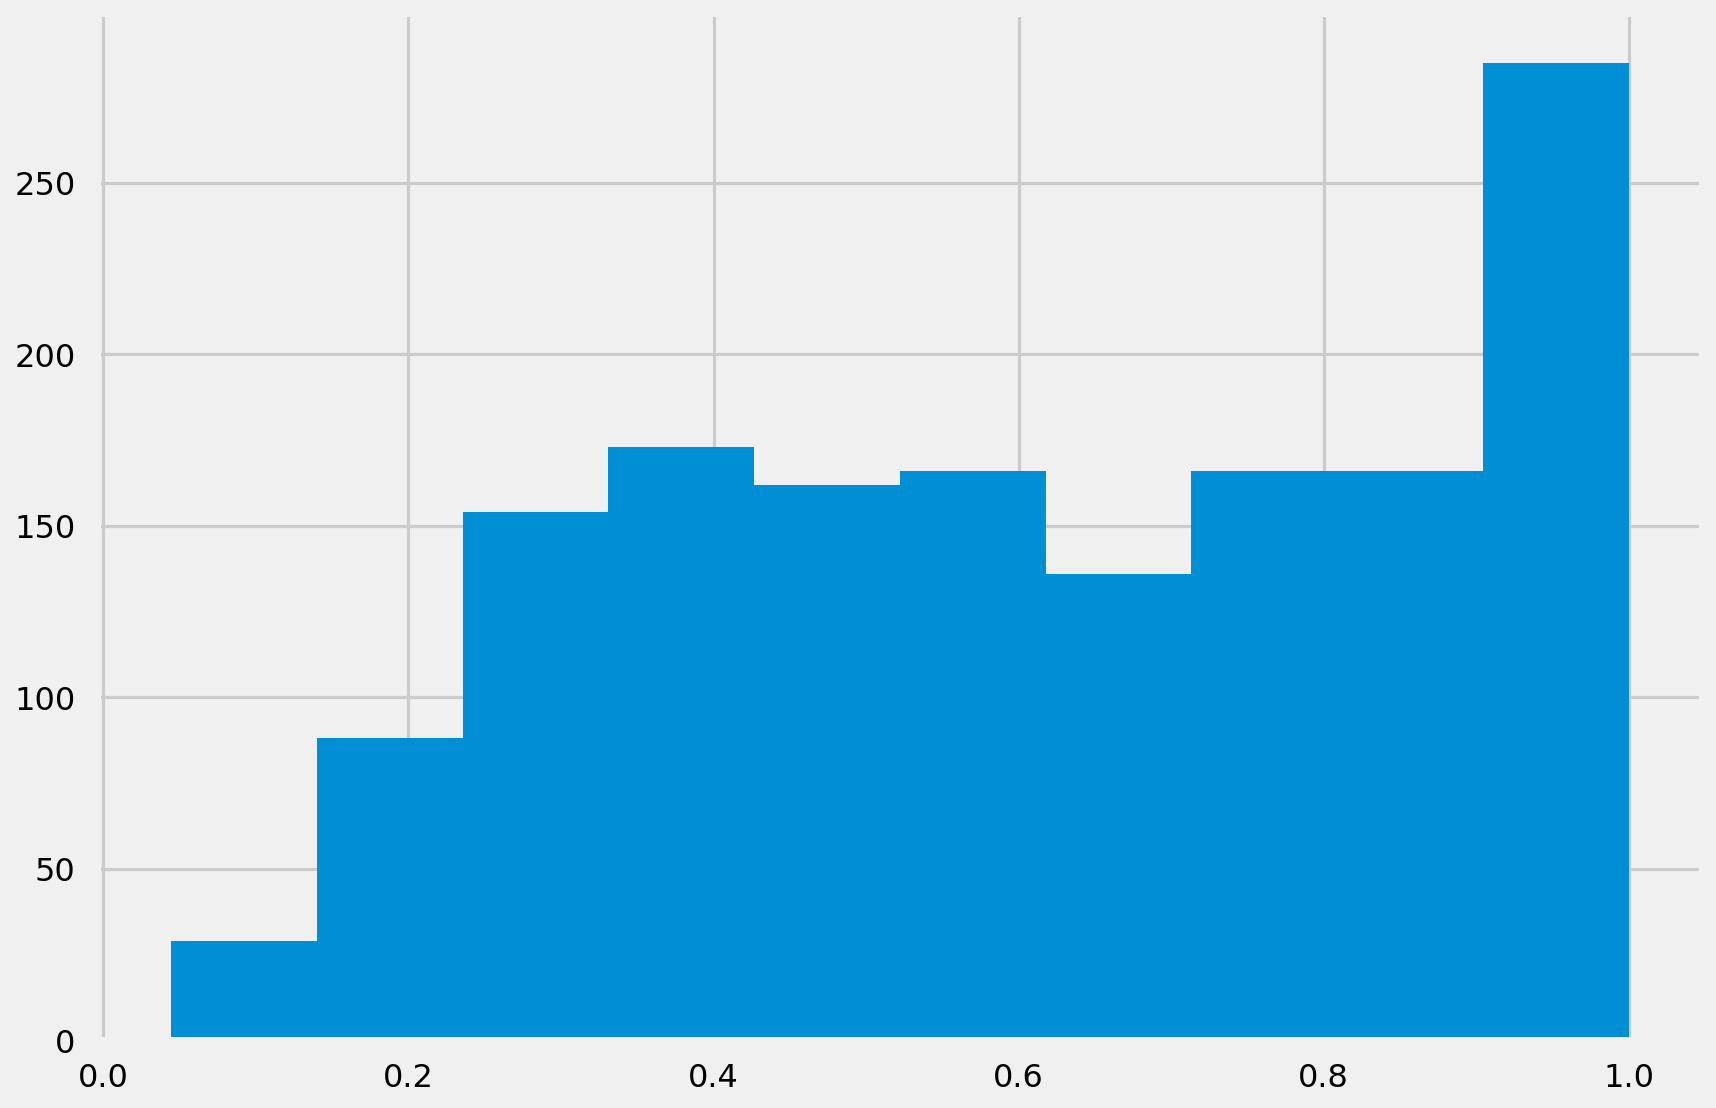

In [19]:
plt.hist(df.query('p1_dog == True')['p1_conf'])

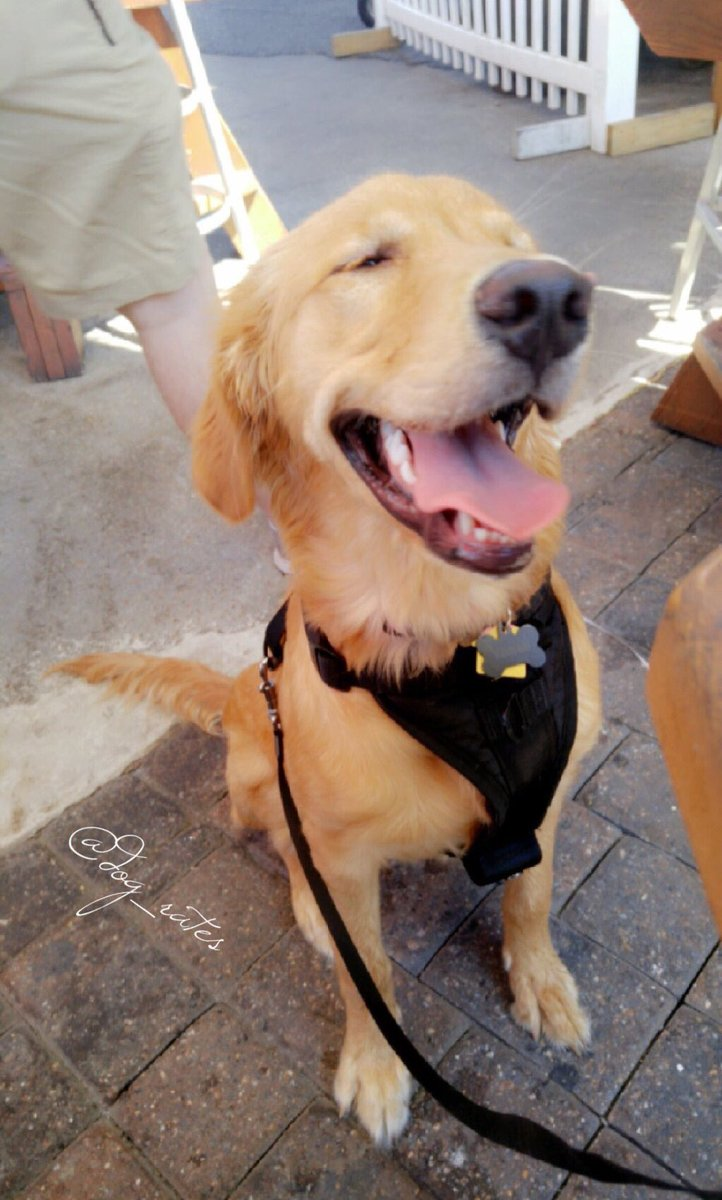

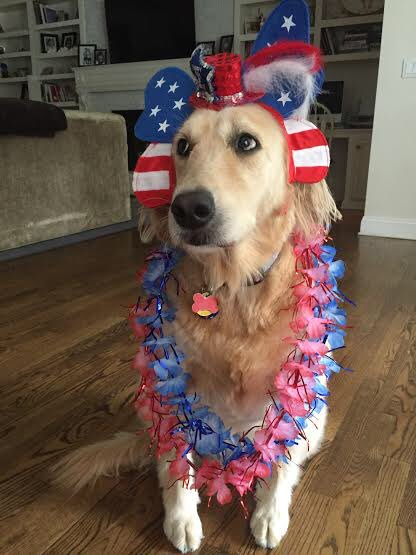

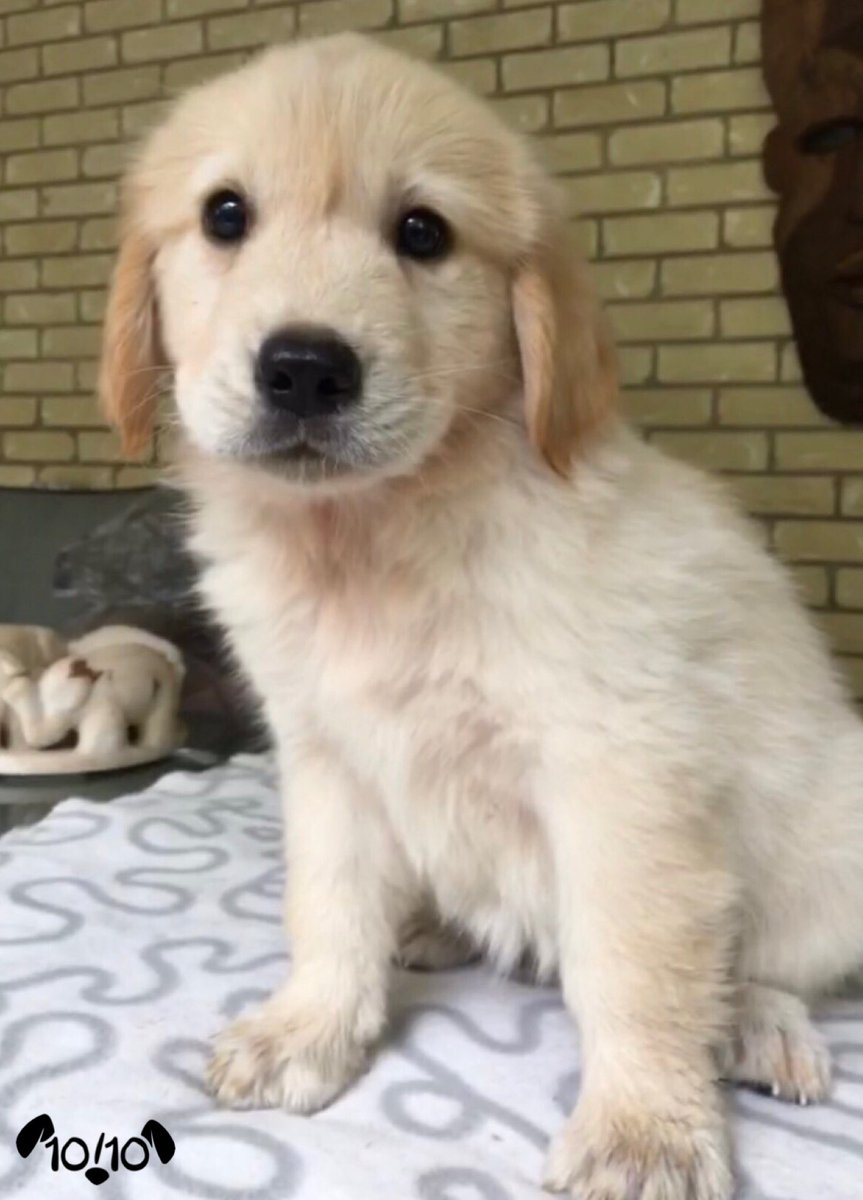

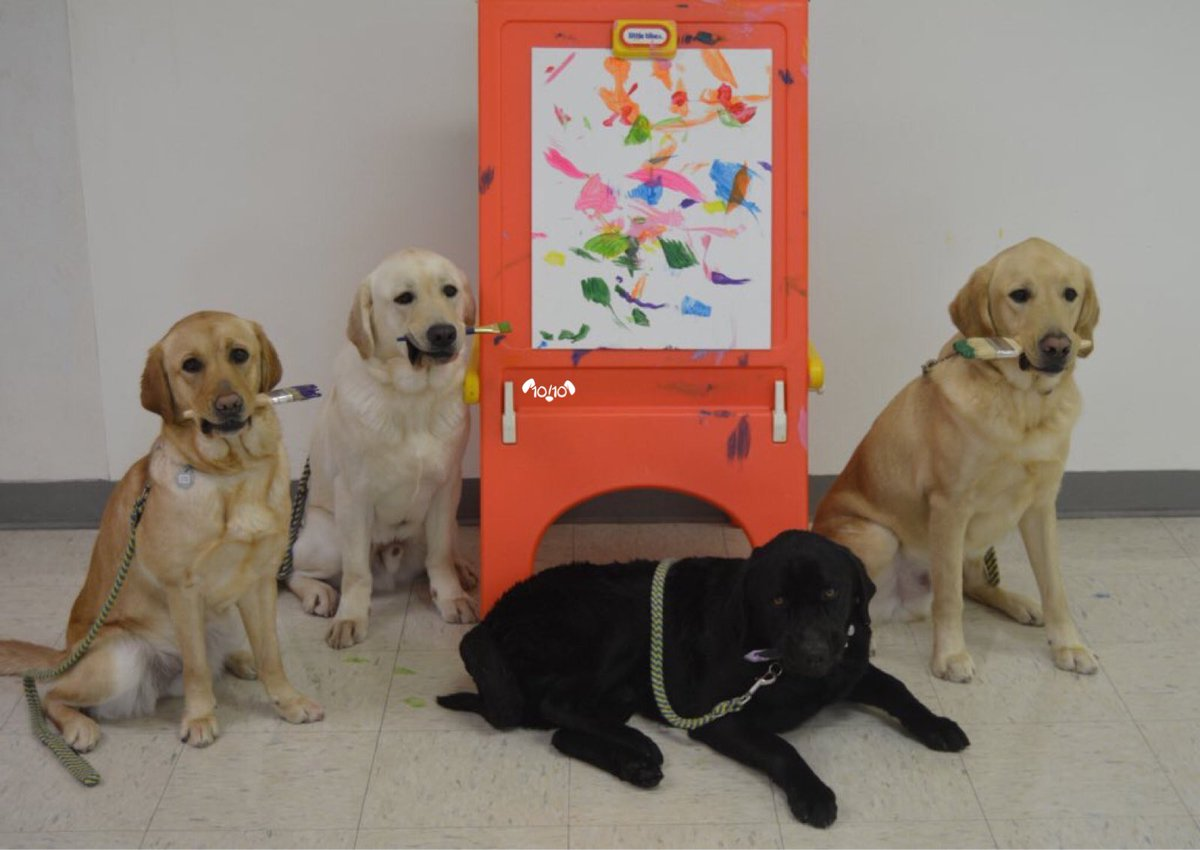

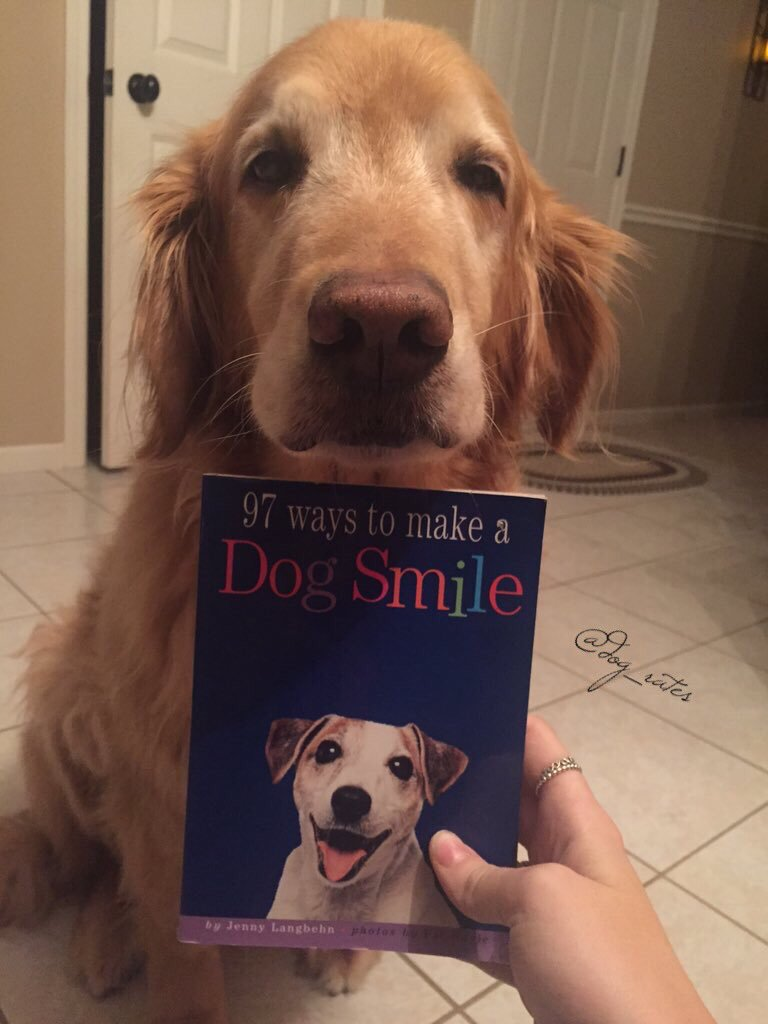

In [20]:
# Pick 10 random golden retrievers
images = df.query('p1 == "golden_retriever"').sample(n=5)

# Display the images
for i, j in images.iterrows(): 
    img = Image(url = j['jpg_url'], format = 'jpg', width = 200, embed=True)
    display(img)

In [21]:
df.p1.value_counts().head(10)

golden_retriever      150
Labrador_retriever     98
Pembroke               88
Chihuahua              81
pug                    57
chow                   44
Samoyed                42
toy_poodle             39
Pomeranian             38
cocker_spaniel         30
Name: p1, dtype: int64